# Stenglein method adaption for magnet data
This file checks the stenglein method for N87
 * 1. load N87 from magnet challenge dataset
 * 2. re-calculate stenglein parameters for N87
 * 3. calculate losses using re-calculated stenglein parameters
 * 4. compare the measurement results with the calculation results


# Parameters

In [1]:
filepath = '/home/nikolasf/Dokumente/01_git/30_Python/MC_UPB/data/input/processed'
material_name = 'N87'

## 1. Load N87 dataset from magnet data

In [2]:
import pandas as pd
import numpy as np

material_data = pd.read_pickle(f'{filepath}/{material_name}.pkl.gz')

## 1a. Preparate data for visualization

In [45]:
import platform
from matplotlib import pyplot as plt
print(platform.python_version())

x_vec = np.linspace(0, 1023, 1024)

b_vec = []
h_vec = []
for value in x_vec:
    b_vec.append(f'B_t_{int(value)}')
    h_vec.append(f'H_t_{int(value)}')
    
    
material_df_usable = pd.DataFrame()
material_df_usable["b"] = material_data[b_vec].values.tolist()
material_df_usable["h"] = material_data[h_vec].values.tolist()
material_df_usable["temp"] = material_data["temp"]
material_df_usable["freq"] = material_data["freq"]
material_df_usable["ploss"] = material_data["ploss"]

3.11.3


# Sort curves by flux waveforms


In [46]:
def i_rms(time, current) -> float:
    """
    RMS calculation from a time-current-vector

    :param time_current_matrix: time and current in format [[0, 0.5e-6, 2.5e-6, 3e-6, 5e-6], [16.55, -10.55, -16.55, 10.55, 16.55]]
    :type time_current_matrix: np.array
    :return: rms current
    :rtype: float
    """
    square_integral_sum = 0

    # set up function
    for count, value in enumerate(time[0:-1]):
        # figure out linear equation between points
        y_axis = current[count]
        delta_time = time[count + 1] - time[count]
        delta_current = current[count + 1] - current[count]
        gradient = delta_current / delta_time

        # calculate solution of (partly) square integral
        square_integral = gradient ** 2 / 3 * delta_time ** 3 + gradient * delta_time ** 2 * y_axis + y_axis ** 2 * delta_time

        # add (partly) square integral to total integration sum
        square_integral_sum += square_integral

    # return "mean" and "root" to finalize rms calculation
    return np.sqrt(square_integral_sum / time[-1])

material_df_usable_sin = pd.DataFrame()

for index, row in material_df_usable.iterrows():
    b_rms = i_rms(x_vec, row["b"])
    b_peak = np.max(row["b"])
    
    tolerance_relative = 0.005
    crest_factor = 1.41
    
    if (1-tolerance_relative) * crest_factor < b_peak / b_rms < (1+tolerance_relative) * crest_factor:
        material_df_usable_sin = material_df_usable_sin._append(material_df_usable.iloc[index])
        
    


In [57]:
print("all waveforms")
print("temperatures:")
print(pd.unique(material_df_usable["temp"]))
print("frequencies:")
print(np.sort(pd.unique(material_df_usable["freq"])))

print("------------------------------")

print("sinusoidal waveforms")
print("temperatures:")
print(pd.unique(material_df_usable_sin["temp"]))
print("frequencies:")
print(np.sort(pd.unique(material_df_usable_sin["freq"])))

all waveforms
temperatures:
[25 50 70 90]
frequencies:
[ 49950.  49960.  49970.  49980.  49990.  50000.  50010.  50020.  50030.
  50040.  50050.  50060.  50070.  50080.  50090.  50100.  50110.  50130.
  50140.  50150.  50160.  56150.  56160.  56170.  56180.  56190.  56200.
  56210.  56220.  56230.  56240.  56250.  56260.  56270.  56300.  56310.
  56320.  56330.  56340.  63010.  63020.  63030.  63040.  63050.  63060.
  63080.  63090.  63100.  63110.  63120.  63130.  63140.  63150.  63170.
  63180.  63190.  63210.  63220.  63230.  63240.  70750.  70760.  70770.
  70780.  70790.  70800.  70810.  70820.  70830.  70840.  70850.  70860.
  70870.  70880.  79400.  79410.  79420.  79430.  79440.  79450.  79460.
  79470.  79480.  79490.  79500.  79510.  79520.  79530.  79540.  89070.
  89080.  89090.  89100.  89110.  89120.  89130.  89140.  89150.  89160.
  89170.  89180.  89190.  89200.  89210.  89220.  99900.  99910.  99920.
  99930.  99940.  99950.  99960.  99970.  99980.  99990. 100000. 1000

# Double check sinusoidal plots

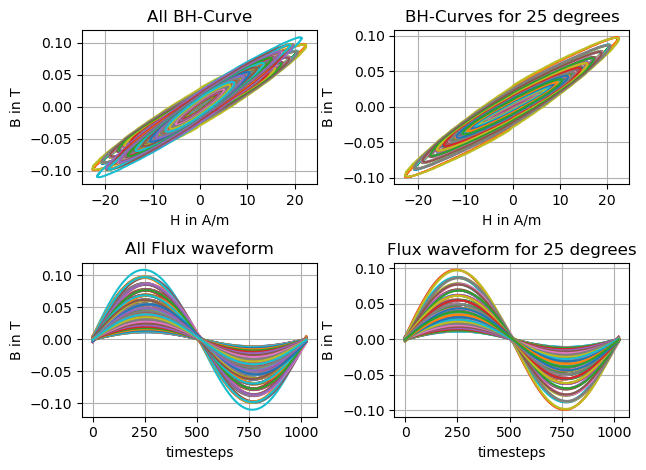

In [52]:

figure, axis = plt.subplots(2,2)

#set up labels for all temperature
axis[0,0].set_title("All BH-Curve")
axis[1,0].set_title("All Flux waveform")
axis[0,0].set_xlabel("H in A/m")
axis[0,0].set_ylabel("B in T")
axis[1,0].set_xlabel("timesteps")
axis[1,0].set_ylabel("B in T")
axis[0,0].grid()
axis[1,0].grid()


#set up labels for 25 degree
axis[0,1].set_title("BH-Curves for 25 degrees")
axis[1,1].set_title("Flux waveform for 25 degrees")
axis[0,1].set_xlabel("H in A/m")
axis[0,1].set_ylabel("B in T")
axis[1,1].set_xlabel("timesteps")
axis[1,1].set_ylabel("B in T")
axis[0,1].grid()
axis[1,1].grid()



figure.tight_layout()

for index, row in material_df_usable_sin.iterrows():
    
    axis[0,0].plot(row["h"], row["b"])
    axis[1,0].plot(x_vec, row["b"])
    
    if row["temp"] == 25:
        axis[0,1].plot(row["h"], row["b"])
        axis[1,1].plot(x_vec, row["b"])
        

# go on with 25°C measurments.
# GEt W_hyst
